# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program


----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np

### Import the MNIST Dataset

In [2]:
from keras.datasets import mnist
(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
X_raw_train, X_raw_valid, y_raw_train, y_raw_valid = train_test_split(X_raw, y_raw, test_size= 1./3, random_state=42)

In [4]:
n_train, n_valid, n_test = X_raw_train.shape[0], X_raw_valid.shape[0], X_raw_test.shape[0]
print n_train, n_valid, n_test

40000 20000 10000


### Combine the Digits
1-5 digits combine one image

In [5]:
num_digits = 5
width = 28
height = 28

def multi_digits(X, y):
    X_len = X.shape[0]
    
    X_gen = np.zeros([X_len, height, num_digits*width, 1], dtype=np.uint8)
    y_gen = np.zeros([X_len, num_digits], dtype=np.uint8)
   
    for i, image in enumerate(X):
        n_img = random.randint(0, num_digits-1)
        X_img = image
        y_img = [y[i]]
        
        for ii in range(n_img):
            img_id = random.randint(0, X_len - 1) 
            X_img = np.concatenate((X_img, X[img_id]), axis=1)
            y_img.append(y[img_id])
        for k in range(4-n_img):
            y_img.append(10)
        zeros = np.zeros((height, width*(num_digits-n_img-1)))
        X_img = np.concatenate((X_img, zeros), axis=1).reshape(-1, height, num_digits*width, 1)
        
        X_gen[i] = X_img
        y_gen[i] = y_img    
             
    return X_gen, y_gen

X_train, y_train = multi_digits(X_raw_train, y_raw_train)
X_valid, y_valid = multi_digits(X_raw_valid, y_raw_valid)
X_test, y_test   = multi_digits(X_raw_test, y_raw_test)

### Shuffle the Dataset

In [6]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

X_train, y_train = randomize(X_train, y_train)
X_valid, y_valid = randomize(X_valid, y_valid)
X_test, y_test = randomize(X_test, y_test)

### Display the  Synthetic Data 
Each image has space for 5 digits, with the empty digit labelled as 10

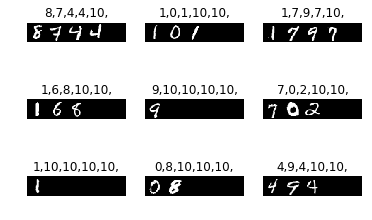

In [7]:
%matplotlib inline
for i in range(9):
    plt.subplot(3, 3, i+1)
    index = random.randint(0, n_test)
    title = ''
    for j in range(5):
        title += str(y_test[index][j]) + ','    
    plt.title(title)
    plt.imshow(X_test[index].reshape(28, 140), cmap='gray')
    plt.axis('off')

### Preprocess Class Labels for Keras

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D 
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.models import Model

Using TensorFlow backend.


In [3]:
# Convert 1-dimensional class arrays to 11-dimensional(0-10) class matrices
def labels_encode(labels):
    y_encode = np.ndarray(shape=(len(labels), labels.shape[1], 11), dtype=np.uint8)
    for i in range(labels.shape[1]):
        y_encode[:,i,:] = np_utils.to_categorical(labels[:,i], 11)
    return y_encode

In [16]:
y_train_encode = labels_encode(y_train)
y_valid_encode = labels_encode(y_valid)
y_test_encode  = labels_encode(y_test)

print X_train.shape
print y_train_encode.shape
X_train_sample = X_train[:10000]
y_train_sample = y_train_encode[:10000]
X_valid_sample = X_valid[:2500]
y_valid_sample = y_valid_encode[:2500]
X_test_sample = X_test[:2500]
y_test_sample = y_test_encode[:2500]

(40000, 28, 140, 1)
(40000, 5, 11)


### Build the Model

In [11]:
def conv_model():
    model_input = Input(shape=(28, 140, 1))
    model = Sequential()
    model.add(Convolution2D(32, 5, 5,  border_mode='same', input_shape=(28, 140, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
        
    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
        
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    y1 = Dense(11, activation='softmax')(model(model_input))
    y2 = Dense(11, activation='softmax')(model(model_input))
    y3 = Dense(11, activation='softmax')(model(model_input))
    y4 = Dense(11, activation='softmax')(model(model_input))
    y5 = Dense(11, activation='softmax')(model(model_input))

    return Model(input=model_input, output=[y1, y2, y3, y4, y5])

In [17]:
model = conv_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_sample, [y_train_sample[:,i,:] for i in range(5)], batch_size= 32, nb_epoch= 10,\
          verbose=2, validation_data=(X_valid_sample, [y_valid_sample[:,i,:] for i in range(5)]))

Train on 10000 samples, validate on 2500 samples
Epoch 1/10
242s - loss: 2.4808 - dense_8_loss: 0.6890 - dense_9_loss: 0.6065 - dense_10_loss: 0.5031 - dense_11_loss: 0.4084 - dense_12_loss: 0.2739 - dense_8_acc: 0.7689 - dense_9_acc: 0.7989 - dense_10_acc: 0.8365 - dense_11_acc: 0.8737 - dense_12_acc: 0.9227 - val_loss: 0.6033 - val_dense_8_loss: 0.1785 - val_dense_9_loss: 0.1512 - val_dense_10_loss: 0.0786 - val_dense_11_loss: 0.1196 - val_dense_12_loss: 0.0754 - val_dense_8_acc: 0.9400 - val_dense_9_acc: 0.9552 - val_dense_10_acc: 0.9788 - val_dense_11_acc: 0.9632 - val_dense_12_acc: 0.9784
Epoch 2/10
239s - loss: 0.5341 - dense_8_loss: 0.1542 - dense_9_loss: 0.1197 - dense_10_loss: 0.1199 - dense_11_loss: 0.0912 - dense_12_loss: 0.0492 - dense_8_acc: 0.9527 - dense_9_acc: 0.9634 - dense_10_acc: 0.9598 - dense_11_acc: 0.9714 - dense_12_acc: 0.9846 - val_loss: 0.4085 - val_dense_8_loss: 0.1135 - val_dense_9_loss: 0.0940 - val_dense_10_loss: 0.0581 - val_dense_11_loss: 0.0974 - val_de

### Performace on Testset

In [19]:
correct_preds = 0
y_pred_list  = model.predict(X_test_sample)
y_val_list = [y_test_sample[:,i,:] for i in range(5)]
n_sample = X_test_sample.shape[0]
correct_digit = np.array([0, 0, 0, 0, 0])

# Iterate over sample dimension
for i in range(n_sample):         
    pred_list_i = [y_pred[i] for y_pred in y_pred_list]
    val_list_i  = [y_val[i] for y_val in y_val_list]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    for j in range(5):
        correct_digit[j] += int(matching_preds[j])
    correct_preds += int(np.all(matching_preds))
    
for i in range(5):
    acc = correct_digit[i]*1.0/n_sample*100
    print "accuracy for digit", i+1, ":", round(acc,1),"%"
total_acc = correct_preds*1.0 /n_sample*100
print "total accuracy", total_acc,"%"

accuracy for digit 1 : 97.6 %
accuracy for digit 2 : 98.2 %
accuracy for digit 3 : 97.9 %
accuracy for digit 4 : 99.1 %
accuracy for digit 5 : 98.8 %
total accuracy 91.92 %


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

At first, it took me quite long time in setting up the Tensorflow. I am used to jupyter notebook under windows, but it doesn't support the tensorflow. I searched the forum, and found suggestion on using windows bash. Following the instructions on https://discussions.udacity.com/t/running-tensorflow-on-windows-10-bash/182113, I set up the bash under windows but the jupyter notebook keeps failing in the start. I googled about the problem and finally found the package installed using apt-get install is not the proper one.

After setting up the tensor flow, I followed the assignments for Udacity Deep Learning class with TensorFlow, using the notMNIST dataset. It's a good start to understand the problem and the use of CNN in the deep learning.

Curious to know what the recommended Keras is, I found some tutorials. I learned how to use Keras and also about the MNIST dataset.  
http://ankivil.com/mnist-database-and-simple-classification-networks/  
https://elitedatascience.com/keras-tutorial-deep-learning-in-python  
I found Keras is indeed a simplified and easy to use interface to Tensorflow. Then I preprosess the images and labels to the format suitable for Keras. 

Then I read Goodfellow's paper. It's really nice work but it's impossible for me to follow since 9 layers would be a nightmare for my surface book. In this first case with synthetic data using MNIST dataset, I suppose 2 or 3 layers could achieve not so bad results.

Then I use a shuffled sample of 1000 training dataset, 500 validation dataset. I trid different combination of parameters in the CNN model, trid two layers and there layers, and used the architeture that has the best accuracy on the validation set. Then I included larger training  samples. With 10000 training samples and 2500 test samples, the total predication accuracy of the model reaches 92%, and single digit accuracy above 97.5%. Using the whole 40000 training samples could further increase the accuracy, but it's limited by the computing power.  

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

The architecture of the model: 

32 filters Convolution of size 5\*5 in "same" border_mode-> Maxpooling with pool size 2\*2-> Batch Normalization -> Drop out frac.0.25 -> Activation Relu  
32 filters Convolution of size 5\*5 in "same" border_mode -> Maxpooling with pool size 2\*2-> Batch Normalization -> Drop out frac.0.25 -> Activation Relu  
32 filters Convolution of size 5\*5 in "same" border_mode -> Drop out frac.0.25 -> Activation Relu  
Flatten  
Fully connected layer(512)-> Activation Relu  

Output:  
digit1:  Fully connected(11) -> Activation Softmax  
digit2:  Fully connected(11) -> Activation Softmax  
digit3:  Fully connected(11) -> Activation Softmax  
digit4:  Fully connected(11) -> Activation Softmax  
digit5:  Fully connected(11) -> Activation Softmax

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

The model is trained using loss function of 'categorical_crossentropy', optimizer 'adam', batch size 32, and using accuracy as the metrics.
20% of the origin trainning dataset is splitted as the validation dataset used in the training.
              
Each image in the MNIST data has a dimension of 28\*28. For each image, it was concatenated horizontally with 0-4 images randomly choosen from the dataset. The synthetic image has a length of 28(height)\*140(width), with extra space excepts the digits filled with empty space. The labels has five numbers with each one representing the corresponding digit in the image. The empty is represented by number 10. This is a simplified model for the realistic case. See the section above "Display the Synthetic Data"  to check the examples of images for better illustration.

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Display the Origin Data

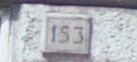

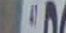

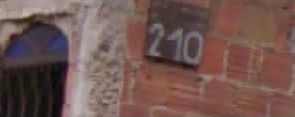

In [4]:
import os
from IPython.display import Image, display
image_name = [img for img in os.listdir('./train') if img.endswith('.png')][2:7]
for m_image in image_name:
    display(Image(filename=os.path.join('./train/',m_image)))

### Preprocessing the Data

In [11]:
from scipy import ndimage
import scipy.misc
import pandas as pd
from skimage import data 
import os
import numpy as np

#The csv files converted from mat are generated as https://github.com/sarahrn/Py-Gsvhn-DigitStruct-Reader
def get_images(csv_file, folder, height=54, width=54, crop=1):
    
    sv_data = pd.read_csv(csv_file)
    sv_data["DigitLabel"] = sv_data["DigitLabel"].replace(10, 0).apply(float)
    sv_data["Right"] = sv_data["Left"] + sv_data["Width"]
    sv_data["Bottom"] = sv_data["Top"] + sv_data["Height"]
    sv_data.drop(["Width", "Height"], inplace=True, axis=1)
    
    # in origin data, 0 is represented by label 10, change it to 0
    sv_data.DigitLabel = sv_data.DigitLabel.replace(10, 0).apply(float)
    # group by Filename as list for digit label and box
    m_data=sv_data.groupby(['FileName']).apply(lambda tdf: pd.Series(dict([[vv,tdf[vv].tolist()] \
                                                                        for vv in tdf if vv not in ['FileName']]))).reset_index()
    '''
    Y Labels
    '''
    n_labels = len(m_data["DigitLabel"])
    labels = 10*np.ones([n_labels, 6], dtype=np.float32)
    for i in range(n_labels):
        labels[i][5] = len(m_data["DigitLabel"][i])
 
        number = m_data.DigitLabel[i]
        j = 0
        for k in range(len(number)):
            labels[i][j] = number[k]
            j += 1

    '''
    X Images
    '''
    X_images = []
    files =  sorted([img for img in os.listdir(folder) if img.endswith('.png')])
    n_images = len(files)

    if not crop:
        # the bounding box for the image
        bbox = np.zeros([n_images, 4], dtype=np.float32)
    
    for i in range(n_images):
    
        filename = os.path.join(folder, files[i])
        image_data = data.imread(filename, as_grey=True)
                          
        left   = min(m_data["Left"][i])
        right  = max(m_data["Right"][i])
        top    = min(m_data["Top"][i])
        bottom = max(m_data["Bottom"][i])
         
        # increase the box by 30%
        left  =  max(0,   int(left - 0.15*(right - left)))
        right =  min(image_data.shape[1],  int(right + 0.15*(right - left)))
        top   =  max(0,   int(top - 0.15*(bottom - top)))
        bottom = min(image_data.shape[0], int(bottom + 0.15*(bottom - top)))
         
        if(crop):
            image_data = image_data[top:bottom, left:right]
        else:
            left =   width * left / image_data.shape[1]
            right =  width * right / image_data.shape[1]
            top  =   height * top / image_data.shape[0]
            bottom = height * bottom / image_data.shape[0]
        
            bbox[i][0] = left
            bbox[i][1] = right
            bbox[i][2] = top
            bbox[i][3] = bottom
        
        # resize to uniform size
        image_data = scipy.misc.imresize(image_data, (height, width, 1), interp='bilinear')
        image_data = image_data.reshape(height, width, 1)
  
        X_images.append(image_data)

    X_images = np.asarray(X_images)
    if(crop):
        return X_images, labels
    else:
        return X_images, labels, bbox

In [6]:
X_train, y_train = get_images('train/digitStruct_train.csv', './train/')
X_test, y_test   = get_images('test/digitStruct_test.csv', './test/')

In [7]:
from sklearn.model_selection import train_test_split
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train, y_train, test_size= 0.2, random_state=42)

### Img and Label Consistency Check

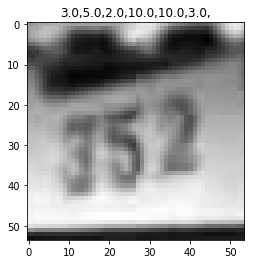

In [35]:
import matplotlib.pyplot as plt
import random 
%matplotlib inline

index = random.randint(0, len(X_train_split))
plt.imshow(X_train_split[index].reshape(54,54),cmap='gray')
title = ''
for j in range(6):
    title += str(y_train_split[index][j]) + ','    
plt.title(title)

In [8]:
y_train_sample = labels_encode(y_train_split)
y_valid_sample = labels_encode(y_valid_split)
y_test_sample  = labels_encode(y_test)

X_train_sample = X_train_split
X_valid_sample = X_valid_split
X_test_sample = X_test

print X_train_sample.shape
print y_train_sample.shape

(26721, 54, 54, 1)
(26721, 6, 11)


### Inital result

In [10]:
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D
def cnn_model():
    model_input = Input(shape=(54, 54, 1))
    model = Sequential()
    model.add(Convolution2D(32, 5, 5,  border_mode='same', input_shape=(54, 54, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
        
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    
    model.add(LocallyConnected2D(128, 3, 3))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
   
    y1 = Dense(11, activation='softmax')(model(model_input))
    y2 = Dense(11, activation='softmax')(model(model_input))
    y3 = Dense(11, activation='softmax')(model(model_input))
    y4 = Dense(11, activation='softmax')(model(model_input))
    y5 = Dense(11, activation='softmax')(model(model_input))
    y6 = Dense(11, activation='softmax')(model(model_input))

    return Model(input=model_input, output=[y1, y2, y3, y4, y5, y6])

In [142]:
model = cnn_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_sample, [y_train_sample[:,i,:] for i in range(6)], batch_size= 64, nb_epoch= 40,\
               verbose=2, validation_data=(X_valid_sample, [y_valid_sample[:,i,:] for i in range(6)]))

Train on 26721 samples, validate on 6681 samples
Epoch 1/40
460s - loss: 3.7888 - dense_16_loss: 1.0699 - dense_17_loss: 1.3260 - dense_18_loss: 0.7682 - dense_19_loss: 0.1985 - dense_20_loss: 0.0089 - dense_21_loss: 0.4173 - dense_16_acc: 0.6460 - dense_17_acc: 0.5650 - dense_18_acc: 0.7719 - dense_19_acc: 0.9558 - dense_20_acc: 0.9981 - dense_21_acc: 0.8396 - val_loss: 2.3402 - val_dense_16_loss: 0.7072 - val_dense_17_loss: 0.8014 - val_dense_18_loss: 0.4904 - val_dense_19_loss: 0.1253 - val_dense_20_loss: 0.0017 - val_dense_21_loss: 0.2142 - val_dense_16_acc: 0.7804 - val_dense_17_acc: 0.7438 - val_dense_18_acc: 0.8512 - val_dense_19_acc: 0.9635 - val_dense_20_acc: 0.9999 - val_dense_21_acc: 0.9223
Epoch 2/40
444s - loss: 2.1668 - dense_16_loss: 0.5820 - dense_17_loss: 0.7404 - dense_18_loss: 0.4886 - dense_19_loss: 0.1303 - dense_20_loss: 0.0036 - dense_21_loss: 0.2219 - dense_16_acc: 0.8123 - dense_17_acc: 0.7607 - dense_18_acc: 0.8499 - dense_19_acc: 0.9646 - dense_20_acc: 0.9997

In [144]:
correct_preds = 0
y_pred_list  = model.predict(X_test_sample)
y_val_list = [y_test_sample[:,i,:] for i in range(6)]
n_sample = X_test_sample.shape[0]
correct_digit = np.array([0, 0, 0, 0, 0, 0])

# Iterate over sample dimension
for i in range(n_sample):         
    pred_list_i = [y_pred[i] for y_pred in y_pred_list]
    val_list_i  = [y_val[i] for y_val in y_val_list]
    matching_preds = [pred.argmax(-1) == val.argmax(-1) for pred, val in zip(pred_list_i, val_list_i)]
    for j in range(6):
        correct_digit[j] += int(matching_preds[j])
    correct_preds += int(np.all(matching_preds))
    
for i in range(6):
    acc = correct_digit[i]*1.0/n_sample*100
    print "accuracy for digit", i+1, ":", round(acc,1),"%"
total_acc = correct_preds*1.0 /n_sample*100
print "Total accuracy(all digits correct)", total_acc,"%"

accuracy for digit 1 : 88.8 %
accuracy for digit 2 : 87.1 %
accuracy for digit 3 : 94.8 %
accuracy for digit 4 : 99.3 %
accuracy for digit 5 : 100.0 %
accuracy for digit 6 : 95.8 %
Total accuracy(all digits correct) 76.936026936 %


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

The training and testing data uses the SVHN format 1 dataset, and they are preprocessed with the same approach. The images are read in the grey scale. The bouding box is calculated for the entire digits in the image and incresed by 30%. Then the area within the bouding box are cropped from the image and resized to 54\*54. 20% of the training set are splitted as the validation set used in the training. And it has a shape of (N, 54, 54, 1), with N indicating number of training samples. For the labels, the digits of the same image are stored with the same sequence as the images from left to right in an array of length 6. In the dataset, digit 0 is represented by 10 in the label. And I changed the label from 10 back to 0. Because 10 is used to represent empty. The sixth position in the array stores the total number of digits in the image. Then they are encoded to 11-dimensional(0-10) class matrices. The labels of the training and test data has a shape of (N, 6, 11).  

On the test dataset, the average accuracy of for predicating the 5 digits in each image are 89%, 87%, 95%, 99%, 100%, respectively. It's no surprising that the latter two digits positions get near 100% accuracy, since most of the images only have 2-3 digits. The total accuracy is defined as the ratio of test samples with all digits in each image predicated correctly to the total number of the test samples. And the model has a total accuracy of 76.9%. 

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

The model trained in the last section cannot be applied directly to the realistic dataset, with a total accuracy in predication around 20%. To achieve "good" results, the bounding box information for each digit in the SVHN dataset is used. The bouding box for all the digits are calculated and enlarged by 30%. Then the area in this bounding box are croped from the image and resized to 54\*54. Besides, I also made several changes to the model according to the performace on small dataset. Based on the previous model in the last section, a locally connected layer with 128 convolution filters of 3\*3 is added before flatten.  Maxpooling and bach normalization is added after the third convolution layer. And I also add the sixth number indicating total number of digits in the image in the labels.  

Unsuccessful attempts: I tried to change the border mode from "same" to "valid", adding depth for the convolution, tune a higher drop out rate. These attempts all lead to a lower accuracy. So these changes are not applied.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

For this realistic dataset, my initial results on the total accuracy is around 20%, and the final results reaches 77%. It's not good enough at classifying numbers correctly. But I think it's acceptable results considering the limiting computing power(my Surface Book got quite hot after long time computing). There's still much improvements that could be made with stronger computing resources like GPU:  
(1) The model can be trained with more epochs. I trained the model for 40 epochs. And the loss keeps decreasing without reaching a stable value.  
(2) More convolution layers can be added. I only use 3 convolution layers here. It's proved in I. Goodfellow's paper that more layers can improve accuracy.  
(3) The SVHN also has an extra dataset, which can be added in the training dataset.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Caputured Pictures  
1. '57' from number on the door
2. '3' from apple bag
3. '90' from chocolate package
4. '50' from ice logo of the laboratory
5. '30' from a speed limit sign

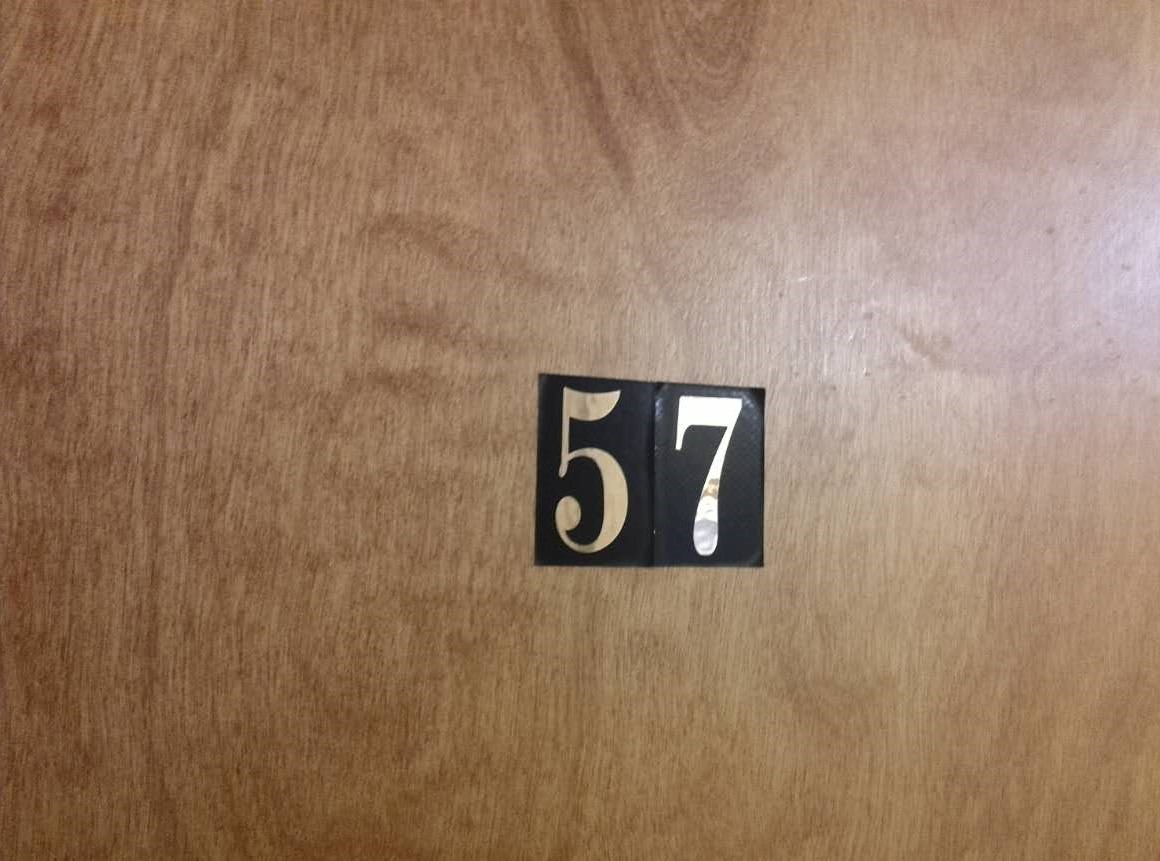

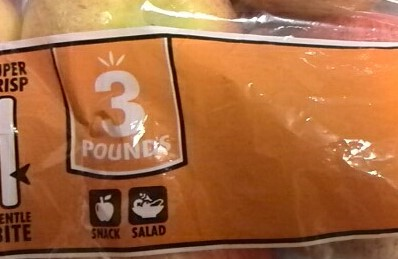

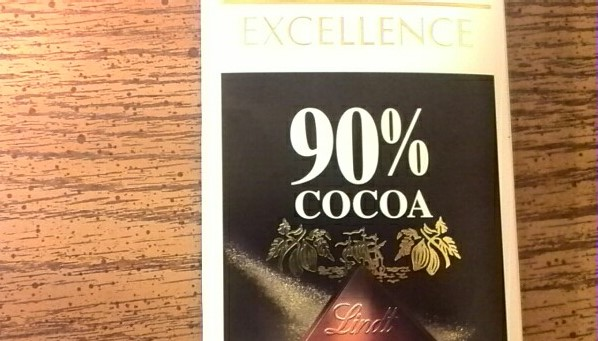

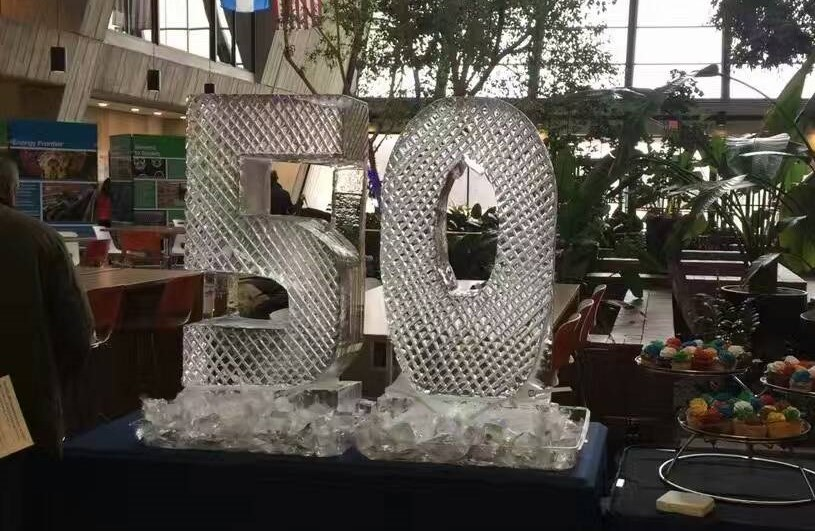

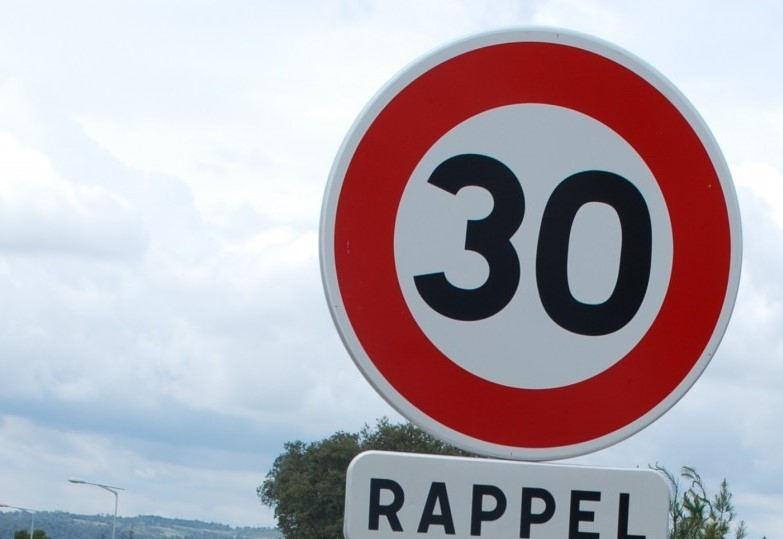

In [169]:
import os
from IPython.display import Image, display
image_name = [img for img in os.listdir('./practise/') if img.endswith('.png')]
for m_image in image_name:
    display(Image(filename=os.path.join('./practise/',m_image), width=200, height=200))

#### Read in the images for the Model

In [9]:
from skimage import data 
import os

def capture_images(folder, height=54, width=54):
    
    X_images = []
    files =  sorted([img for img in os.listdir(folder) if img.endswith('.png')])

    for i in range(len(files)):
        filename = os.path.join(folder, files[i])
        image_data = data.imread(filename, as_grey=True)                                   
        # resize to uniform size
        image_data = scipy.misc.imresize(image_data, (height, width, 1), interp='bilinear')
        image_data = image_data.reshape(height, width, 1)
        X_images.append(image_data)

    X_images = np.asarray(X_images)
    return X_images

In [171]:
X_capture = capture_images("./practise/")

#### Predications without image cropping 

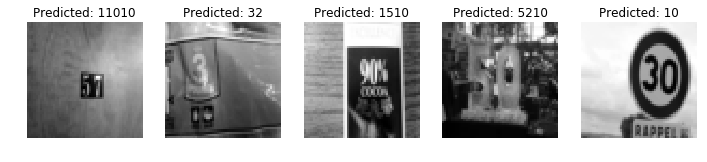

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline

y_pred_list  = cnnmodel.predict(X_capture)
n_sample = X_capture.shape[0]

# Iterate over sample dimension
for i in range(n_sample):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_capture[i].reshape(54,54), cmap='gray')
    
    pred_list_i = [y_pred[i] for y_pred in y_pred_list] 

    ndigits = pred_list_i[5].argmax(-1)    
    title = 'Predicted: '
    for j in range(ndigits):
        title += str(pred_list_i[j].argmax(-1))     
    fig = plt.gcf()
    fig.set_size_inches(12, 10)    
    plt.title(title)
    plt.axis('off')   

From the results above, none of the image has correct predication. The model's poor performance is as expected because the model is trained with cropped images with only digits. The above images has too many contents around the numbers. Let's see the results after the cropping the image with only digits left by hand.   

#### Predications after image cropping

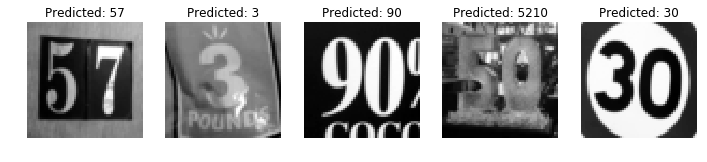

In [173]:
X_capture = capture_images("./practise2/")
n_sample = X_capture.shape[0]
y_pred_list  = cnn_model.predict(X_capture)

# Iterate over sample dimension
for i in range(n_sample):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_capture[i].reshape(54,54), cmap='gray')
    
    pred_list_i = [y_pred[i] for y_pred in y_pred_list] 

    ndigits = pred_list_i[5].argmax(-1)    
    title = 'Predicted: '
    for j in range(ndigits):
        title += str(pred_list_i[j].argmax(-1))     
    fig = plt.gcf()
    fig.set_size_inches(12, 10)    
    plt.title(title)
    plt.axis('off')   

From the results above, the model correctly predicate the numbers in image 1,2,3,5. And it has wrong predication on image 4. 

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

See the section above for the images and the model's predication. The model can perform well with digits centered in the picture and other elements removed. This model has poor performance without the bounding box of the image. It also has difficulties in predicating images with digits on complex background layer, like the case in captured image 4. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

Yes. The model has correct predications in 4 of 5 the captured pictures. The total accuracy of the model on the realistic dataset is 76.9%. 

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Prepare the Dataset
Load the dataset without cropping the image. And read in the scaled bounding box of the image.  

In [4]:
X_train, y_train, bbox_train = get_images('train/digitStruct_train.csv', './train/', height=54, width=54, crop=0)
X_test, y_test, bbox_test   = get_images('test/digitStruct_test.csv', './test/', height=54, width=54, crop=0)   

In [5]:
from sklearn.model_selection import train_test_split
X_train_split, X_valid_split, y_train_split, y_valid_split, bbox_train_split, bbox_valid_split =\
                            train_test_split(X_train, y_train, bbox_train, test_size= 0.2, random_state=42)

In [6]:
X_train_sample = X_train_split
X_valid_sample = X_valid_split
X_test_sample = X_test

y_train_sample = y_train_split
y_valid_sample = y_valid_split
y_test_sample  = y_test

bbox_train_sample = bbox_train_split
bbox_valid_sample = bbox_valid_split 
bbox_test_sample = bbox_test 

print X_train_sample.shape
print y_train_sample.shape
print bbox_train_sample.shape

(26721, 54, 54, 1)
(26721, 6)
(26721, 4)


### Show the Image and Digits in the Bounding Box 

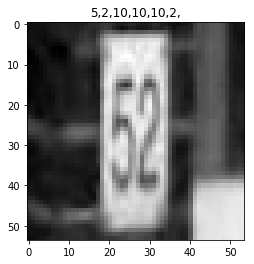

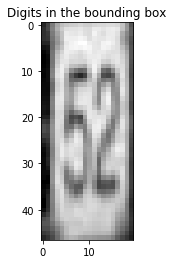

In [109]:
import matplotlib.pyplot as plt
import random 
%matplotlib inline

index = random.randint(0, len(X_train_split))
plt.imshow(X_train_split[index].reshape(54, 54), cmap='gray')
title = ''
for j in range(6):
    title += str(int(y_train_split[index][j])) + ','    
plt.title(title)
plt.show()
bbox = bbox_train_split[index].astype(int)
title = "Digits in the bounding box"
plt.imshow(X_train_split[index].reshape(54, 54)[bbox[2]:bbox[3], bbox[0]:bbox[1]], cmap='gray')
plt.title(title)
plt.show()

#### Build the Model

In [12]:
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D
def box_model():
    model_input = Input(shape=(54, 54, 1))
    model = Sequential()
    model.add(Convolution2D(32, 5, 5,  border_mode='same', input_shape=(54, 54, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 5, 5, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
        
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    
    model.add(LocallyConnected2D(128, 5, 5))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
   
    y1 = Dense(1)(model(model_input))
    y2 = Dense(1)(model(model_input))
    y3 = Dense(1)(model(model_input))
    y4 = Dense(1)(model(model_input))
    
    return Model(input=model_input, output=[y1, y2, y3, y4])

In [13]:
bbmodel = box_model()
bbmodel.compile(loss='mean_squared_error',
                optimizer='adam',            
                metrics=['mean_squared_error'])

bbmodel.fit(X_train_sample, [bbox_train_sample[:,i] for i in range(4)], batch_size= 32, nb_epoch= 50, verbose=2)

Epoch 1/50
390s - loss: 101.0249 - dense_2_loss: 18.5490 - dense_3_loss: 26.9367 - dense_4_loss: 18.5091 - dense_5_loss: 37.0300 - dense_2_mean_squared_error: 18.5490 - dense_3_mean_squared_error: 26.9367 - dense_4_mean_squared_error: 18.5091 - dense_5_mean_squared_error: 37.0300
Epoch 2/50
392s - loss: 66.4536 - dense_2_loss: 12.9715 - dense_3_loss: 17.2905 - dense_4_loss: 13.5950 - dense_5_loss: 22.5965 - dense_2_mean_squared_error: 12.9715 - dense_3_mean_squared_error: 17.2905 - dense_4_mean_squared_error: 13.5950 - dense_5_mean_squared_error: 22.5965
Epoch 3/50
385s - loss: 59.7818 - dense_2_loss: 11.4053 - dense_3_loss: 15.6722 - dense_4_loss: 11.9057 - dense_5_loss: 20.7986 - dense_2_mean_squared_error: 11.4053 - dense_3_mean_squared_error: 15.6722 - dense_4_mean_squared_error: 11.9057 - dense_5_mean_squared_error: 20.7986
Epoch 4/50
385s - loss: 54.8408 - dense_2_loss: 10.3747 - dense_3_loss: 14.4298 - dense_4_loss: 11.0090 - dense_5_loss: 19.0273 - dense_2_mean_squared_error: 1

In [3]:
bbmodel.save('bb_model.h5') 

In [117]:
from keras.models import load_model
bbmodel_load = load_model('bb_model.h5')

#### Performance of the Model

To test the performance of the model on the test dataset, a metric is defined as follows:  
p $\cap$ g / p $\cup$ g  
where p is the area within the predicted bounding box of the image; g is the area of the image's bounding box provided in the dataset.

In [4]:
def line_over(a1, a2, b1, b2):
    list=[a1,a2,b1,b2]
    list.sort()
    if((list[1]==a2 and list[2]==b1) or (list[1]==b2 and list[2]==a1)):
        length=0
    else:
        length = list[2] - list[1]
    return length
def box_area(left, right, top, bottom):
    return (right-left)*(bottom-top)
def area_percentage(left1, right1, top1, bottom1, left2, right2, top2, bottom2):
    overlap_area =  line_over(left1, right1, left2, right2)*line_over(top1, bottom1, top2, bottom2)
    total_area = box_area(left1, right1, top1, bottom1) + box_area(left2, right2, top2, bottom2)
    return overlap_area*1.0/(total_area - overlap_area)

def get_bbox(bbox, index, predict):
    if(predict):
        left = bbox[0][index]
        right = bbox[1][index]
        top = bbox[2][index]
        bottom = bbox[3][index]
    else:
        left = bbox[index][0]
        right = bbox[index][1]
        top = bbox[index][2]
        bottom = bbox[index][3]
    return left, right, top , bottom

In [30]:
pred_box = bbmodel_load.predict(X_test_sample)
n_samples = len(X_test_sample)
sum = 0;
for i in range(n_samples):
    left, right, top, bottom = get_bbox(bbox_test_sample, i, 0)
    p_left, p_right, p_top, p_bottom = get_bbox(pred_box, i, 1)
    sum += area_percentage(left, right, top, bottom, p_left, p_right, p_top, p_bottom)
print "average", round(sum/n_samples*100, 1), '%'   

average 61.5 %


#### Example of the Predicated Bounding Box on the Test Dataset

69.8 %


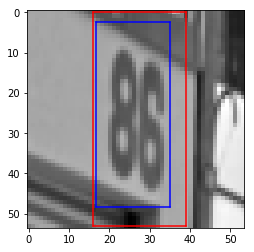

In [29]:
%matplotlib inline
index = random.randint(0, len(X_test_sample)-1)

plt.imshow(X_test_sample[index].reshape(54,54), cmap='gray')
#plot the box in the dataset
left, right, top, bottom = get_bbox(bbox_test_sample, index, 0)

plt.plot([left, right], [top, top], color='r')
plt.plot([left, right], [bottom, bottom], color='r')
plt.plot([left, left],  [top, bottom], color='r')
plt.plot([right, right], [top, bottom], color='r')

p_left, p_right, p_top, p_bottom = get_bbox(pred_box, index, 1)

plt.plot([p_left, p_right], [p_top, p_top], color='b')
plt.plot([p_left, p_right], [p_bottom, p_bottom], color='b')
plt.plot([p_left, p_left],  [p_top, p_bottom], color='b')
plt.plot([p_right, p_right], [p_top, p_bottom], color='b')

print round(area_percentage(left, right, top, bottom, p_left, p_right, p_top, p_bottom)*100, 1), '%'

The blue box is the predicated result, and the red box is from the original dataset. 

### Predicated Bounding Box on the Original Captured Images

In [174]:
X_capture = capture_images("./practise/")

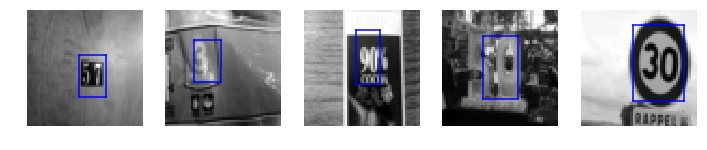

In [175]:
pred_box = bbmodel_load.predict(X_capture)

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_capture[i].reshape(54,54), cmap='gray')

    left = pred_box[0][i]
    right = pred_box[1][i]
    top = pred_box[2][i]
    bottom = pred_box[3][i]

    plt.plot([left, right], [top, top], color='b')
    plt.plot([left, right], [bottom, bottom], color='b')
    plt.plot([left, left],  [top, bottom], color='b')
    plt.plot([right, right], [top, bottom], color='b')

    fig = plt.gcf()
    fig.set_size_inches(12, 10)    
    plt.axis('off')   

#### Crop the Image Using the Predicated Box

In [176]:
captured_images_crop = []
folder = "practise/"
height = 54
width = 54

files =  sorted([img for img in os.listdir(folder) if img.endswith('.png')])

for i in range(5):               
    filename = os.path.join(folder, files[i])
    image_data = data.imread(filename, as_grey=True)
                          
    left = int(pred_box[0][i])
    right = int(pred_box[1][i])
    top = int(pred_box[2][i])
    bottom = int(pred_box[3][i])
    
    # anti scale from 54*54 -> origin 
    left = left * image_data.shape[1]/ width  
    right = right * image_data.shape[1]/ width
    top  =   top * image_data.shape[0] / height
    bottom = bottom * image_data.shape[0] / height
    
    image_data = image_data[top:bottom, left:right]
    image_data = scipy.misc.imresize(image_data, (height, width, 1), interp='bilinear')
    image_data = image_data.reshape(height, width, 1)
    captured_images_crop.append(image_data)

captured_images_crop= np.asarray(captured_images_crop)
print captured_images_crop.shape

(5, 54, 54, 1)


#### Predication on the Captured Image after Image Crop using the Predicated Box

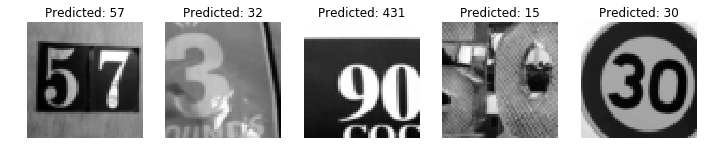

In [177]:
y_pred_list  = cnnmodel.predict(captured_images_crop)
n_sample = captured_images_crop.shape[0]

for i in range(n_sample):
    plt.subplot(1, 5, i+1)
    plt.imshow(captured_images_crop[i].reshape(54, 54), cmap='gray')
    
    pred_list_i = [y_pred[i] for y_pred in y_pred_list] 

    ndigits = pred_list_i[5].argmax(-1)    
    title = 'Predicted: '
    for j in range(ndigits):
        title += str(pred_list_i[j].argmax(-1))     
    fig = plt.gcf()
    fig.set_size_inches(12, 10)    
    plt.title(title)
    plt.axis('off')   

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

To test the performance of the model on the test dataset, a metric is defined as follows:  
m = p $\cap$ g / p $\cup$ g  
where p is the area within the predicted bounding box of the image; g is the area of the image's bounding box provided in the dataset.  
And the avearage m of the trained model on the testing set is 61.5%.

Because in Step2, the model already used the bounding box information. And the predicated box by the model is not accurate as the box information  with the dataset. So the model in Step2 can not be improved with this localization for dataset that contains bounding box information. 

For dataset without bounding box information, this localization is useful at improving the digit recongnition accuracy. We can see the examples of the captured images above. Without localization, none of the number in the images are predicated correctly. After the image crop using the localization predicated by the bounding box model, two of the five images get correct predication. This classification result can be further improved with a better predication of the bounding box location. One possible improvement would be to train the bounding box for each digit instead of the whole number.  

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

See the section of "Predicated Bounding Box on the Original Captured Images" above. The bounding box calculated by the localization function roughly captures the digits in the images, but the position is not very accurate. Image 3, extra space in the vertical direction. Image 2, little right shifted. Image 4, capture part of the digits. Image 1 and 5, proper position.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.